
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [138]:
import time
import math

import pandas as pd

from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *


Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
imputation_method = 'Univariate'
target_index = 'AAPL'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [139]:
FinancialRatios.index = FinancialRatios.index.set_levels([pd.to_datetime(FinancialRatios.index.levels[0]).tz_localize(None), FinancialRatios.index.levels[1]])
TechnicalAnalysis.index = TechnicalAnalysis.index.set_levels([pd.to_datetime(TechnicalAnalysis.index.levels[0]).tz_localize(None), TechnicalAnalysis.index.levels[1]])

In [143]:
ContextualInfo

adjRet_mean_20  adjRet_median_20  adjRet_std_20  \
date       ticker                                                    
1994-11-30 AAPL               NaN               NaN            NaN   
           ABT                NaN               NaN            NaN   
           ADBE               NaN               NaN            NaN   
           ADI                NaN               NaN            NaN   
           ADM                NaN               NaN            NaN   
...                           ...               ...            ...   
2023-04-30 X             0.000235          0.004598       0.021108   
           XRAY          0.005813          0.005972       0.010028   
           XRX          -0.001792         -0.000330       0.020347   
           ZBRA         -0.000002          0.000149       0.017557   
           ZION          0.003964          0.012183       0.035879   

                   adjRet_q1_20  adjRet_q3_20  adjRet_mean_40  \
date       ticker                                               
1994-11-30 AAPL             NaN           NaN             NaN   
           ABT              NaN           NaN             NaN   
           ADBE             NaN           NaN             NaN   
           ADI              NaN           NaN             NaN   
           ADM              NaN           NaN             NaN   
...                         ...           ...             ...   
2023-04-30 X          -0.009262      0.016075       -0.002664   
           XRAY       -0.001491      0.009259        0.004177   
           XRX        -0.020141      0.014169       -0.004084   
           ZBRA       -0.009122      0.005960       -0.000952   
           ZION       -0.024646      0.030038       -0.011101   

                   adjRet_median_40  adjRet_std_40  adjRet_q1_40  \
date       ticker                                                  
1994-11-30 AAPL                 NaN            NaN           NaN   
           ABT                  NaN            NaN           NaN   
           ADBE                 NaN            NaN           NaN   
           ADI                  NaN            NaN           NaN   
           ADM                  NaN            NaN           NaN   
...                             ...            ...           ...   
2023-04-30 X               0.000355       0.029406     -0.019877   
           XRAY            0.005972       0.021815     -0.005877   
           XRX            -0.002198       0.019963     -0.019933   
           ZBRA            0.000408       0.018108     -0.011806   
           ZION            0.003476       0.057924     -0.039450   

                   adjRet_q3_40  ...  ret_crsp       roa      roce       roe  \
date       ticker                ...                                           
1994-11-30 AAPL             NaN  ... -0.134703  0.107575  0.135661  0.108640   
           ABT              NaN  ...  0.028226  0.334654  0.438633  0.393938   
           ADBE             NaN  ... -0.083333  0.298149  0.321503  0.242739   
           ADI              NaN  ... -0.062937  0.224617  0.168125  0.147960   
           ADM              NaN  ... -0.034934  0.142856  0.125429  0.114974   
...                         ...  ...       ...       ...       ...       ...   
2023-04-30 X           0.016075  ...       NaN       NaN       NaN       NaN   
           XRAY        0.013418  ...       NaN       NaN       NaN       NaN   
           XRX         0.012357  ...       NaN       NaN       NaN       NaN   
           ZBRA        0.012314  ...       NaN       NaN       NaN       NaN   
           ZION        0.027007  ...       NaN       NaN       NaN       NaN   

                   sale_equity  sale_invcap   sale_nwc  short_debt  \
date       ticker                                                    
1994-11-30 AAPL       3.855471     3.418722   3.628837    0.489716   
           ABT        2.336299     2.161982  19.120435    0.711391   
           ADBE       1.693104     1.693104   2.001831  

In [142]:
indices = ContextualInfo.index.get_level_values('date') <= start_date
subsetted_index = ContextualInfo.index[indices]
common_tickers = intersection(adjClose.columns, subsetted_index.get_level_values('ticker'))
print(len(common_tickers))

289


In [141]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [144]:
['MKC', 'RF', 'WOR']
idx = pd.IndexSlice
ContextualInfo.loc[idx[:, ['MKC', 'RF', 'WOR']], :]

adjRet_mean_20  adjRet_median_20  adjRet_std_20  \
date       ticker                                                    
1994-11-30 MKC                NaN               NaN            NaN   
           RF                 NaN               NaN            NaN   
           WOR                NaN               NaN            NaN   
1994-12-31 MKC                NaN               NaN            NaN   
           RF                 NaN               NaN            NaN   
...                           ...               ...            ...   
2023-03-31 RF           -0.010310         -0.008993       0.036118   
           WOR           0.002685          0.001245       0.042972   
2023-04-30 MKC           0.009762          0.004757       0.022757   
           RF            0.002429          0.003006       0.015438   
           WOR           0.000038          0.002003       0.015272   

                   adjRet_q1_20  adjRet_q3_20  adjRet_mean_40  \
date       ticker                                               
1994-11-30 MKC              NaN           NaN             NaN   
           RF               NaN           NaN             NaN   
           WOR              NaN           NaN             NaN   
1994-12-31 MKC              NaN           NaN             NaN   
           RF               NaN           NaN             NaN   
...                         ...           ...             ...   
2023-03-31 RF         -0.038776      0.014190       -0.005759   
           WOR        -0.025291      0.021785        0.002384   
2023-04-30 MKC        -0.000400      0.011071        0.003474   
           RF         -0.010060      0.014190       -0.005011   
           WOR        -0.009341      0.011273        0.001380   

                   adjRet_median_40  adjRet_std_40  adjRet_q1_40  \
date       ticker                                                  
1994-11-30 MKC                  NaN            NaN           NaN   
           RF                   NaN            NaN           NaN   
           WOR                  NaN            NaN           NaN   
1994-12-31 MKC                  NaN            NaN           NaN   
           RF                   NaN            NaN           NaN   
...                             ...            ...           ...   
2023-03-31 RF              0.000439       0.026805     -0.017862   
           WOR             0.003078       0.032342     -0.014639   
2023-04-30 MKC             0.001126       0.018487     -0.006479   
           RF              0.001932       0.027616     -0.017862   
           WOR             0.002397       0.031582     -0.013513   

                   adjRet_q3_40  ...  ret_crsp       roa      roce       roe  \
date       ticker                ...                                           
1994-11-30 MKC              NaN  ... -0.126214  0.188339  0.242548  0.222833   
           RF               NaN  ... -0.051282  0.027072  0.125695  0.074771   
           WOR              NaN  ... -0.051528  0.034173  0.191888  0.159874   
1994-12-31 MKC              NaN  ... -0.083333  0.188339  0.242548  0.222833   
           RF               NaN  ...  0.027027  0.027072  0.125695  0.074771   
...                         ...  ...       ...       ...       ...       ...   
2023-03-31 RF          0.007812  ...       NaN       NaN       NaN       NaN   
           WOR         0.013950  ...       NaN       NaN       NaN       NaN   
2023-04-30 MKC         0.009248  ...       NaN       NaN       NaN       NaN   
           RF          0.007870  ...       NaN       NaN       NaN       NaN   
           WOR         0.011887  ...       NaN       NaN       NaN       NaN   

                   sale_equity  sale_invcap  sale_nwc  short_debt  staff_sale  \
date       ticker                                                               
1994-11-30 MKC        1.472366     1.287233  6.390192    0.776465    0.000000   
           RF         1.586893     1.021555  6.612037    0.920379    0.252547   
           W

In [86]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [87]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2022-12-31 00:00:00')

In [88]:
start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

# start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
# 
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [89]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [90]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [91]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [92]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [93]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [94]:
#Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs

#investor preferences (static throughout the backtest)
k = 6*20 #estimation
alpha= 1 - 0.985 #estimation
return_premium = 1.7 #optimization
cardinality_ratio = 0.03 #optimization
turnover_limit = 0.75 # 0.75, 1, 1.25
MipGap = 0.05
limit_time = 30 

q = 1
C = 10**(-3)
epsilon = 10**(-3)



investor_preferences = {'k':k, 'alpha':alpha, 'premium':return_premium,
                        'target_index':target_index, 'turnover_limit':turnover_limit, 
                        'cardinality_ratio': cardinality_ratio,
                        'MipGap' : MipGap, 'limit_time':limit_time}


Strategy = general_strategy(exponential_weighted_estimator, CardMVOPremiumAdjustedTurnover,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator
# 
Strategy.extract_optimization_info = populateCardMVOPremiumAdjustedTurnover

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [109]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

#End of the first investment period
#testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [110]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 1998-12-31 00:00:00
Test End 1999-05-31 00:00:00
Calibration End 1998-12-30 00:00:00


In [126]:
[ticker for ticker in returns.columns  if ticker not in period_Context.index]

['MKC', 'RF', 'WOR']

In [125]:
len(returns.columns)

289

In [124]:
len(period_Context.index)

286

In [111]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

In [127]:
calEnd

Timestamp('1998-12-30 00:00:00')

In [112]:
# Number of assets
n  = len(tickers)
env.n = n

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    #take the last available contextual observations
    period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
    period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
    period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

    env.periodReturns = periodReturns
    env.periodFactRet = periodFactRet
    env.period_daily_adjClose = period_daily_adjClose
    env.period_Context = period_Context
    #there should be a feature vector for each asset
    assert len(period_Context) == n

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]
            #update the previous periods portfolio 
        env.previous_portfolio = x0[:,t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    # add in the estimation info

    x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);
    
    #Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)
    

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

AssertionError: 

# 3. Results

In [99]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
Ret = 12*((portfExRets + 1).apply(gmean, axis=0) - 1)
Vol = (12**0.5)*(portfExRets.std())
SR = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std())

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Annualized return: ', str(Ret[0]))
print('Annualized vol: ', str(Vol[0]))
print('Annualized Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))

Elasped time is 12.772753953933716 seconds
Annualized return:  0.18848421249303815
Annualized vol:  0.19155089787480778
Annualized Sharpe ratio:  0.9839902322787651
Avg. turnover:  0.7500145303555057


### Observations

        The end to end strategy has the following stats when we use 15 observations:
        Elasped time is 27.749337434768677 seconds
        Sharpe ratio:  0.36926056542515073
        Avg. turnover:  0.2846570354951544

        Standard MVO has the following stats when we use 15 observations::
        
        Elasped time is 1.1906468868255615 seconds
        Sharpe ratio:  0.35584233976844887
        Avg. turnover:  0.6967647038270909

        The end to end strategy has the following stats when we use 35 observations:
        
        Elasped time is 16.95100688934326 seconds
        Sharpe ratio:  0.33129478714103455
        Avg. turnover:  0.13229814142751284

        Standard MVO has the following stats when we use 35 observations:
        
        Elasped time is 1.2436742782592773 seconds
        Sharpe ratio:  0.2997765726515852
        Avg. turnover:  0.25328429647155937


In [100]:
value_target_index = initialVal*(1 + adjClose.pct_change(1).loc[portfValue.index, target_index]).cumprod()
portfValue[target_index] = value_target_index
portfValue.columns = ['Strategy', target_index]

<Figure size 640x480 with 0 Axes>

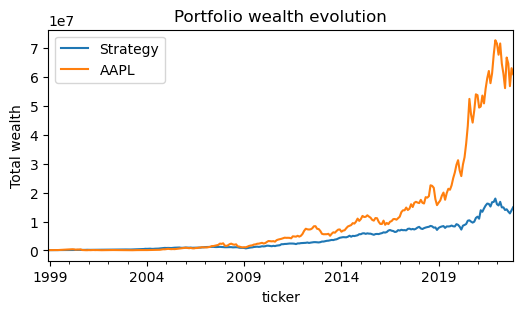

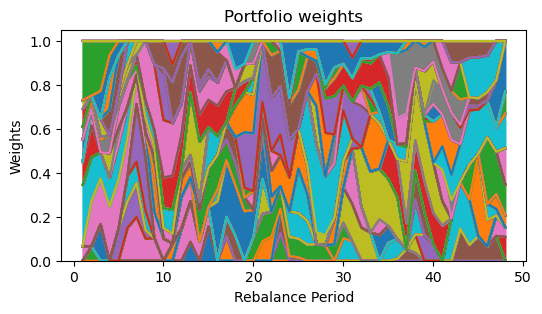

In [101]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = True)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
if n <= 20:
    legend_bool = True
else:
    legend_bool = False
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = legend_bool, stacked = True)
if legend_bool:
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%

In [102]:
weights.iloc[:,-1][weights.iloc[:,-1] > 0.001]

ATVI    0.109026
AZO     0.043107
F       0.054736
IDXX    0.140071
K       0.165448
NEM     0.156255
ODP     0.100526
PFE     0.230831
Name: 48, dtype: float64

In [30]:
(np.abs(daily_adjClose.diff().dropna()) <= 0.001).sum().sort_values()

IWM      9
IJH     10
MDY     10
VBK     11
SPY     12
      ... 
DHF    696
CIF    704
BHV    710
MIN    710
NOM    823
Length: 299, dtype: int64

In [31]:
# Calculate the portfolio Sharpe ratio
ticker_rets = adjClose.pct_change(1).iloc[1:,]
ticker_rets = ticker_rets.loc[portfRets.index]

tickerExRets = ticker_rets.subtract(riskFree[(riskFree.index >= ticker_rets.index[0])&(riskFree.index <= ticker_rets.index[-1])], axis = 0)

tickerSR = ((tickerExRets + 1).apply(gmean, axis=0) - 1)/tickerExRets.std()

In [67]:
(12**0.5)*tickerSR.sort_values(ascending=False)

VDC    0.704875
XLP    0.696787
XLV    0.686137
VHT    0.684758
IYH    0.680974
         ...   
EWP   -0.077192
EWO   -0.088028
EWI   -0.126377
OIH   -0.181022
CEE   -0.258633
Length: 299, dtype: float64